# Building Stochastic Gradient Descent

Z. W. Miller - Copyright 2018

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [20]:
import numpy as np
import pandas as pd

class sgd_classifier:
    
    def __init__(self, n_iter=10, alpha=0.01, verbose=False, return_steps=False, fit_intercept=True, 
                 dynamic=False, loss='ols', epsilon=0.1, random_state=None):
        """
        Stochastic Gradient Descent Algorithm, with Logistic Regression 
        cost function.
        ---
        KWargs:
        
        n_iter: number of epochs to run in while fitting to the data. 
        Total number of steps will be n_iter*X.shape[0]. 
        alpha: The learning rate. Moderates the step size during the 
        gradient descent algorithm.
        verbose: Whether to print out coefficient information during 
        the epochs
        return_steps: If True, fit returns a list of the coefficients 
        at each update step for diagnostics
        fit_intercept: If True, an extra coefficient is added with no 
        associated feature to act as the base prediction if all X are 0.
        dynamic: If true, an annealing scedule is used to scale the learning rate. 
        """
        self.coef_ = None
        self.trained = False
        self.n_iter = n_iter
        self.alpha_ = alpha
        self.verbosity = verbose
        self._return_steps = return_steps
        self._fit_intercept = fit_intercept
        self._next_alpha_shift = 0.1 # Only used if dynamic=True
        self._dynamic = dynamic
        if random_state:
            np.random.seed(random_state)
        self._data_cols = None
        
    def update(self, x, error):
        """
        Calculating the change of the coeficients for SGD. This is the derivative of the cost 
        function. B_i = B_i - alpha * dJ/dB_i. If fit_intercept=True, a slightly different 
        value is used to update the intercept coefficient, since the associated feature is "1."
        ---
        Inputs:
        
        data_point: A single row of the feature matrix. Since this is Stochastic, batches are not allowed.
        
        error: The residual for the current data point, given the current coefficients. Prediction - True
        for the current datapoint and coefficients.
        """
        step = self.alpha_*error*x
        if self._fit_intercept:
            self.coef_[1:] = self.coef_[1:] - step
            self.coef_[0] = self.coef_[0] - self.alpha_ * error
        else:
            self.coef_ = self.coef_ - step
        
    def shuffle_data(self, X, y):
        """
        Given X and y, shuffle them together to get a new_X and new_y that maintain feature-target
        correlations. 
        ---
        Inputs:
        
        X: A numpy array of any shape
        y: A numpy array of any shape
        
        Both X and y must have the same first dimension length.
        
        Returns:
        X,y: two numpy arrays
        """
        assert len(X) == len(y)
        permute = np.random.permutation(len(y))
        return X[permute], y[permute]
    
    def dynamic_learning_rate_check(self, epoch):
        """
        If dynamic=True, shrink the learning rate by a factor of 2 after every 10% of
        the total number of epochs. This should cause a more direct path to the global 
        minimum after the initial large steps.
        ---
        Inputs: epoch (int,float), the current iteration number. 
        """
        percent_of_epochs = float(epoch)/float(self.n_iter)
        if percent_of_epochs > self._next_alpha_shift:
            self._next_alpha_shift += 0.1
            self.alpha_ = self.alpha_/2
            
    def fit(self, X, y):
        """
        Actually trains the model. Given feature-target combinations, gradient descent is performed
        using the optimization stepping given in the 'update' function. At present, all epochs are 
        completed, as no tolerance is set. The learning rate is currently fixed.
        ---
        Inputs: 
            X (array, dataframe, series), The features to regress on using SGD
            y (array, series), Must be a 1D set of targets.
        Outputs:
            steps (optional): If return_steps=True, a list of the evolution of the coefficients is returned
        """
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
        self._stdy = np.std(y)
        self.coef_ = self.init_coef(X)
        if self._return_steps:
            steps = []
            steps.append(np.copy(self.coef_))
        for epoch in range(self.n_iter):
            shuf_X, shuf_y = self.shuffle_data(X,y)
            if self.verbosity:
                print("Epoch ", epoch, ", Coeff: ", self.coef_)
            for data, true in zip(shuf_X,shuf_y):
                pred = self.predict_proba(data, is_array=True)
                error = pred - true
                self.update(data, error)
                if self._return_steps:
                    steps.append(np.copy(self.coef_))
            if self._dynamic:
                self.dynamic_learning_rate_check(epoch)
        if self._return_steps:
            return steps
            
    def init_coef(self, X):
        """
        Returns the initial starting values for the coefficients. At present, these are randomly
        set. If fit_intercept = True, an extra coefficient is generated. 
        ---
        Input: X, Feature matrix. Needed to decide how many coefficients to generate.
        """
        if self._fit_intercept:
            return np.random.rand(X.shape[1]+1)
        return np.random.rand(X.shape[1])

    def predict_proba(self, X, is_array=False):  
        """
        Returns a prediction for a new data set, using the model coefficients.
        ---
        Input: 
            X (dataframe, array): The new feature set. Must be the same number of columns
            as the initial training features. 
        Output:
            prediction (array): The dot product of the input data and the coeficients.
        """
        if not is_array:
            X = self.convert_to_array(X)
        if not self.coef_.all():
            raise ValueError("Coefficients not defined, must fit() before predict().")
        if self._fit_intercept:
            return self.logit(np.dot(X,self.coef_[1:]) + self.coef_[0])
        
        return self.logit(np.dot(X,self.coef_))
    
    def predict(self, X, threshold=0.5):
        """
        Takes the output of predict_proba and applies a threshold
        to the probability value. If the value is greater than the
        threshold, labels the row as class 1. Else class 0.
        """
        preds = self.predict_proba(X)
        preds[preds >= threshold] = 1
        preds[preds < threshold] = 0
        return preds.reshape(-1,1)
    
    def logit(self, beta_x):
        """
        Applies the sigmoid or logit function to current
        linear prediction from beta * X.
        """
        denom = 1. - np.exp(-beta_x)
        val = 1./denom
        
        if type(val) != 'numpy.ndarray':
            val = np.array([val])
            
        # Handle rounding errors!
        val[val>1] = 1
        val[val<0] = 0
        return val
      
    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: accuracy (float)
        """
        pred = self.predict(X)
        correct = 0
        for i,j in zip(y,pred):
            if i == j:
                correct+=1
        return float(correct)/float(len(y))
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x

# Let's get some data to see how it behaves

In [21]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=4, n_clusters_per_class=1)

It will work with Pandas or Numpy arrays. Let's play with Pandas for now.

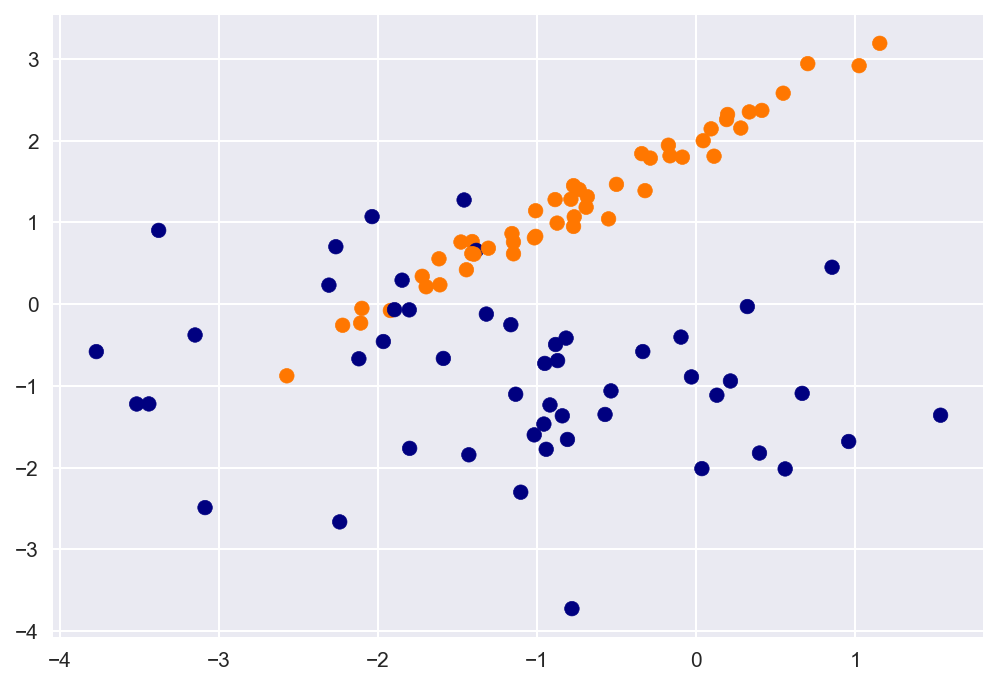

In [22]:
plt.figure(dpi=150)
plt.scatter(X[:,0],X[:,1],c=plt.cm.jet(y*200));

In [23]:
sgd = sgd_classifier(n_iter=20, alpha=1e-3, verbose=False, return_steps=True, dynamic=False, random_state=42)

In [24]:
steps = sgd.fit(X,y)

In [25]:
sgd.coef_

array([ 0.48254012,  0.50833568,  0.77470392])

In [26]:
sgd.score(X,y)

0.85

0.85


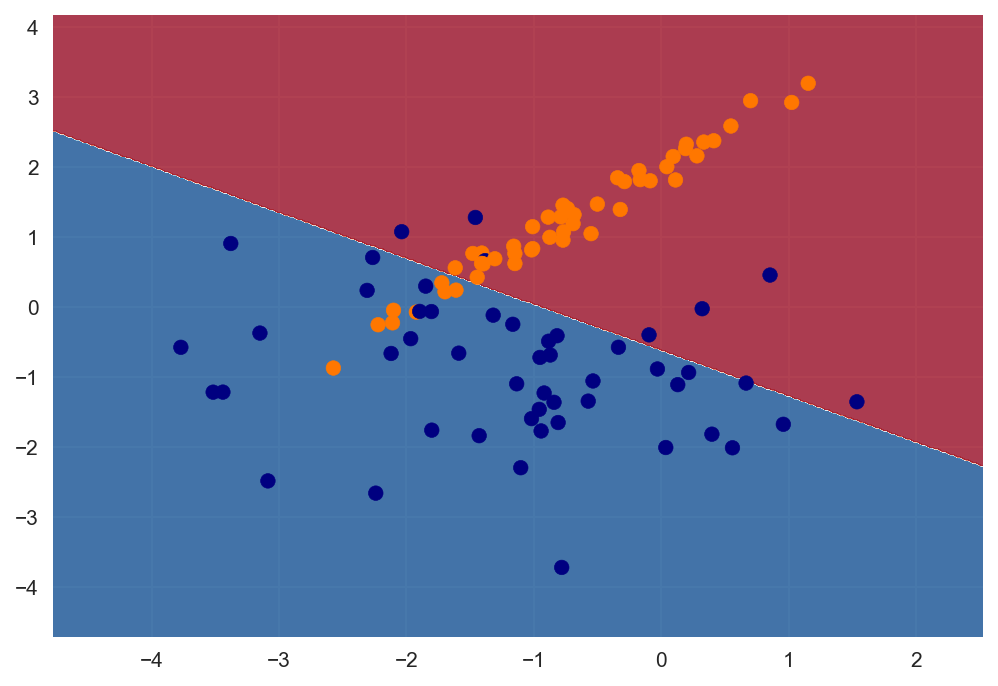

In [27]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

print(sgd.score(X,y))
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plt.figure(dpi=150)
ax = plt.gca()
plot_contours(ax, sgd, xx, yy,cmap=plt.cm.RdBu_r, alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=plt.cm.jet(y*200));

0.87


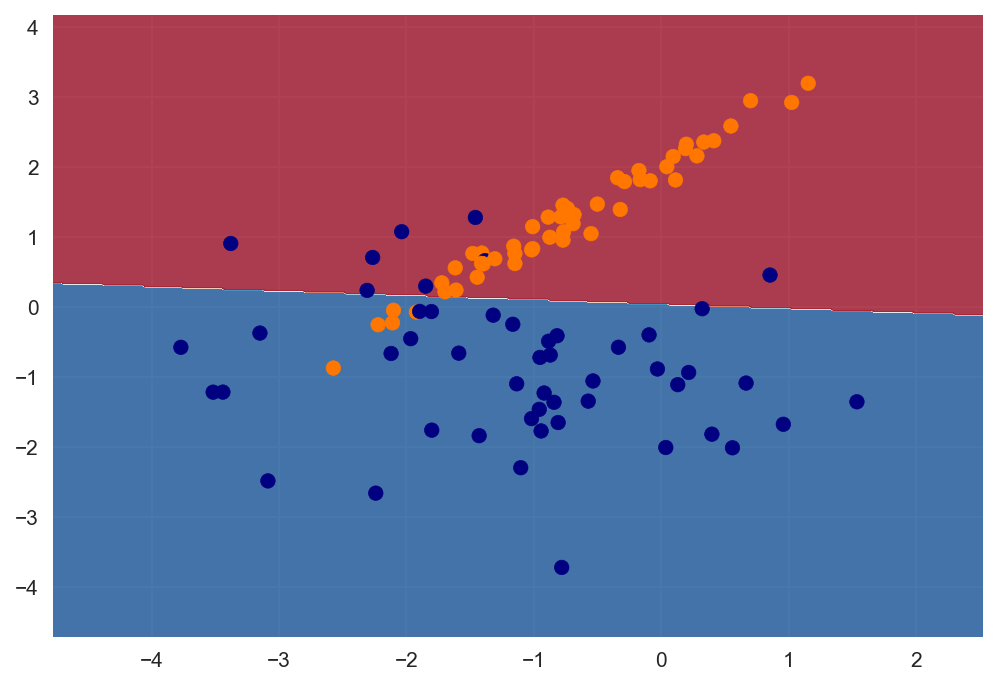

In [28]:
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(penalty='none', max_iter=20, eta0=1e-3, learning_rate='constant', random_state=42)
lr.fit(X,y)
print(lr.score(X,y))
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plt.figure(dpi=150)
ax = plt.gca()
plot_contours(ax, lr, xx, yy,cmap=plt.cm.RdBu_r, alpha=0.8)
plt.scatter(X[:,0],X[:,1],c=plt.cm.jet(y*200));

## Let's look at how the optimization looks in the Coefficient Space!

In [29]:
def plot_beta_space(steps, components = (0,1), last_300=False, zoom=False):
    plt.figure(figsize=(20,16))
    try:
        B0 = np.array(steps).T[components[0]]
        B1 = np.array(steps).T[components[1]]
    except:
        print("Couldn't find those components, defaulting to (0,1)")
        B0 = np.array(steps).T[0]
        B1 = np.array(steps).T[1]
    if last_300:
        steps_to_show=-300
        skip = 2
        plt.scatter(B0[steps_to_show::skip],B1[steps_to_show::skip],c=plt.cm.rainbow(np.linspace(0,1,len(B0[steps_to_show::skip]))));
        plt.scatter(steps[steps_to_show][0],steps[steps_to_show][1],c='r',marker='x', s=400,label='Start')
        plt.scatter(steps[-1][0],steps[-1][1],c='k',marker='x', s=400,label='End')
        plt.title("Movement in the Coefficient Space, Last "+str(-steps_to_show)+" steps!",fontsize=32);
    else: 
        plt.scatter(B0[::25],B1[::25],c=plt.cm.rainbow(np.linspace(0,1,len(B0[::25]))));
        plt.scatter(steps[0][0],steps[0][1],c='r',marker='x', s=400,label='Start')
        plt.scatter(steps[-1][0],steps[-1][1],c='k',marker='x', s=400,label='End')
        plt.title("Movement in the Coefficient Space",fontsize=32);
    plt.legend(fontsize=32, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
    plt.xlabel("B"+str(components[0]),fontsize=26)
    plt.ylabel("B"+str(components[1]),fontsize=26);
    if zoom:
        plt.ylim(min(B1[steps_to_show::skip]), max(B1[steps_to_show::skip]))
        plt.xlim(min(B0[steps_to_show::skip]), max(B0[steps_to_show::skip]));

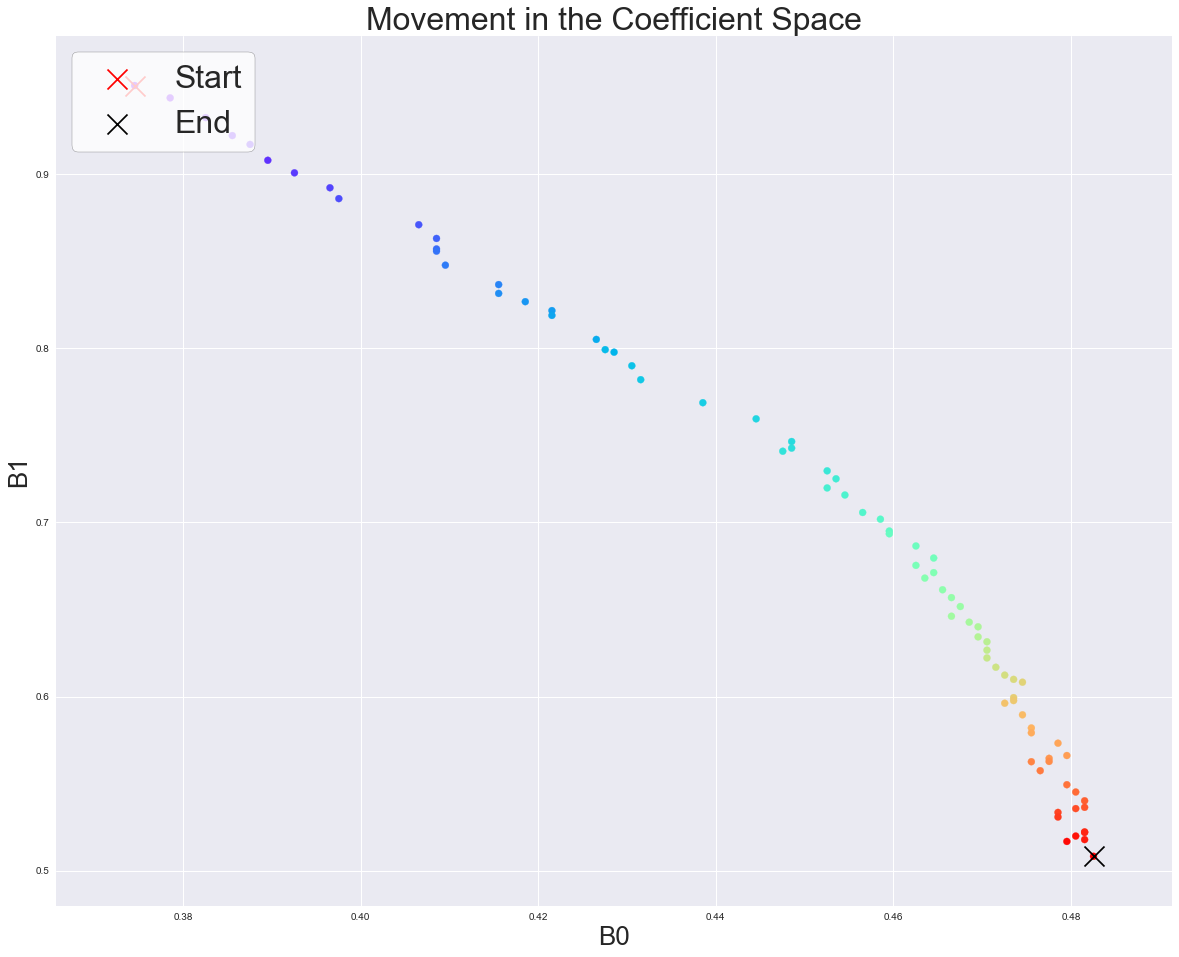

In [30]:
plot_beta_space(steps)

** Now let's look at the last 300 steps. NOTE THE SCALE CHANGE! **

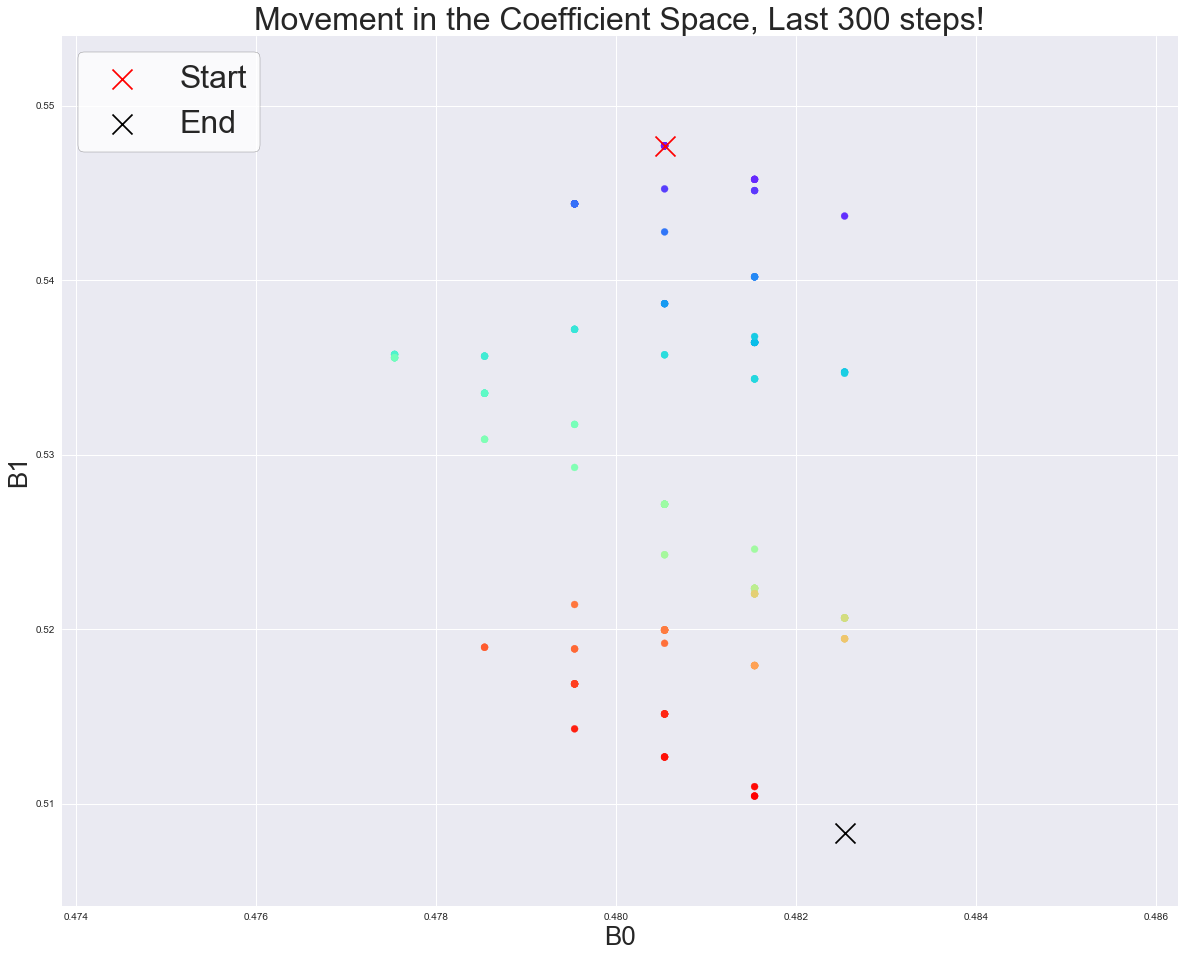

In [31]:
plot_beta_space(steps, last_300=True)

## Let's look at it with dynamic learning rate turned on

In [32]:
sgd2 = sgd_classifier(n_iter=20, alpha=1e-3, verbose=False, return_steps=True, dynamic=True)

In [33]:
steps2 = sgd2.fit(X,y)

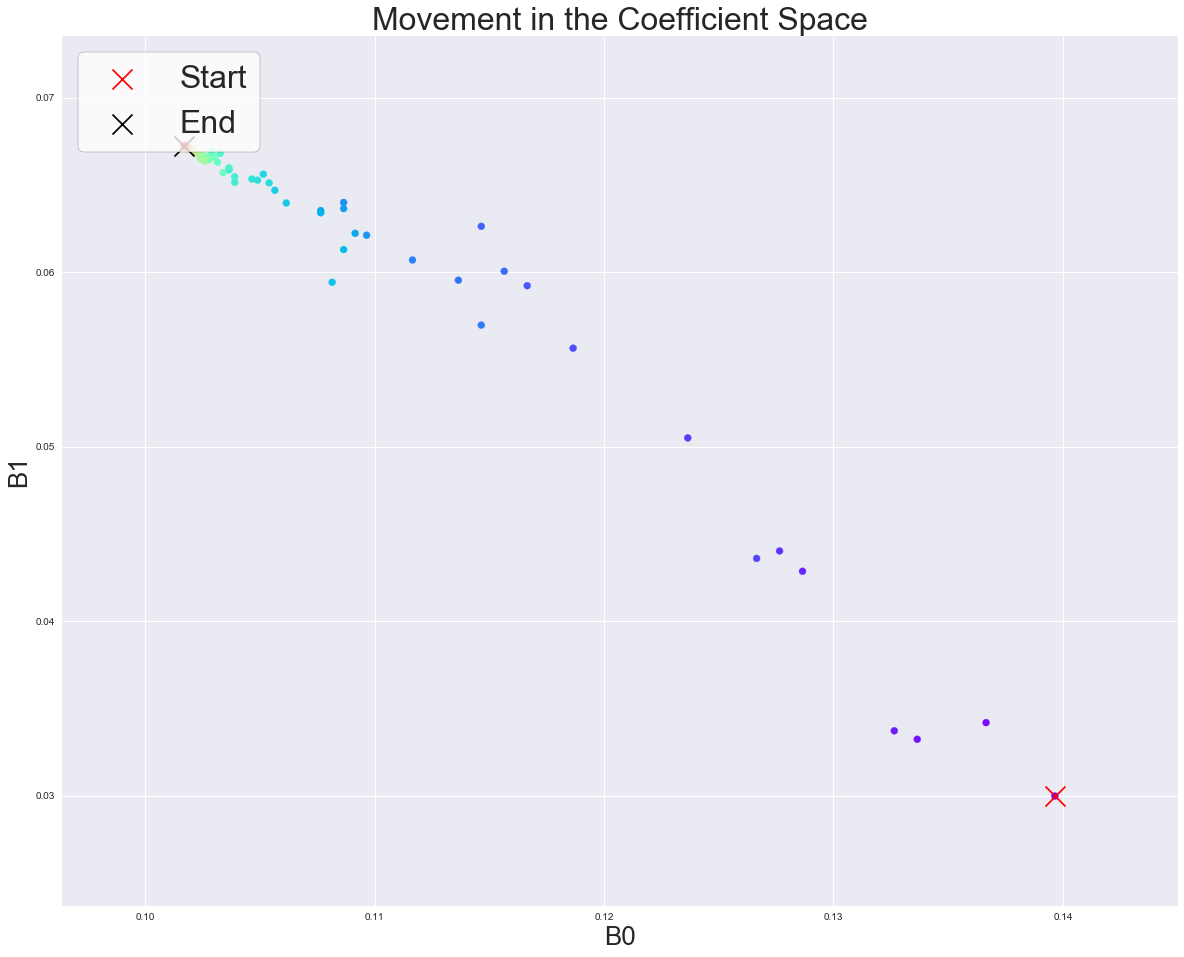

In [34]:
plot_beta_space(steps2)

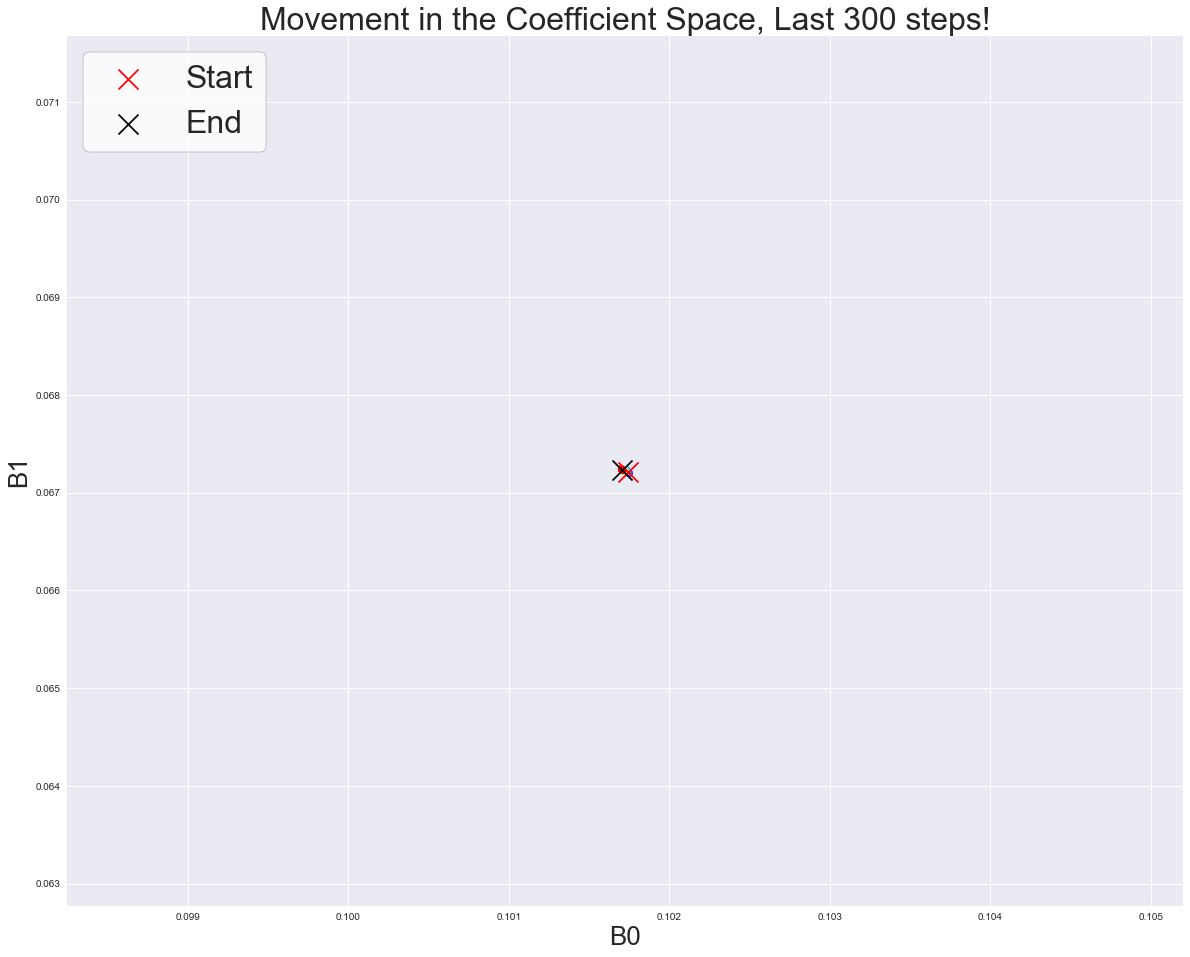

In [35]:
plot_beta_space(steps2, last_300=True)

# Now let's test with some "real data"

In [36]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [37]:
X = pd.DataFrame(StandardScaler().fit_transform(load_breast_cancer().data))
y = load_breast_cancer().target

In [38]:
X.shape

(569, 30)

In [39]:
# Simplest form - fit intercept, no dynamic learning for comparison
sgd = sgd_classifier(n_iter=20, fit_intercept=True, random_state=42, dynamic=True)
sgd.fit(X.iloc[:500],y[:500])

In [40]:
sgd.coef_

array([ 0.06293856,  0.41583887,  0.03106547,  0.05064832, -0.39256665,
       -0.28944197, -0.31774361,  0.10886816, -0.1040129 ,  0.23450854,
        0.00447494,  0.21405634,  0.24343176, -0.45260242, -0.4560118 ,
       -0.17760092,  0.03954167,  0.06262808, -0.17068837,  0.11169422,
        0.36086277, -0.47451197, -0.50290963, -0.23296724, -0.14096964,
        0.123398  , -0.14390189, -0.17879138, -0.14195087, -0.29773283,
        0.21475067])

In [41]:
from sklearn.linear_model import SGDClassifier

sgd_sk = SGDClassifier(loss='log')
sgd_sk.fit(X.iloc[:500],y[:500])

/Users/zachariahmiller/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [42]:
new_X = X.iloc[500:]
my_pred = sgd.predict_proba(new_X)
sk_pred = sgd_sk.predict_proba(new_X)[:,1]

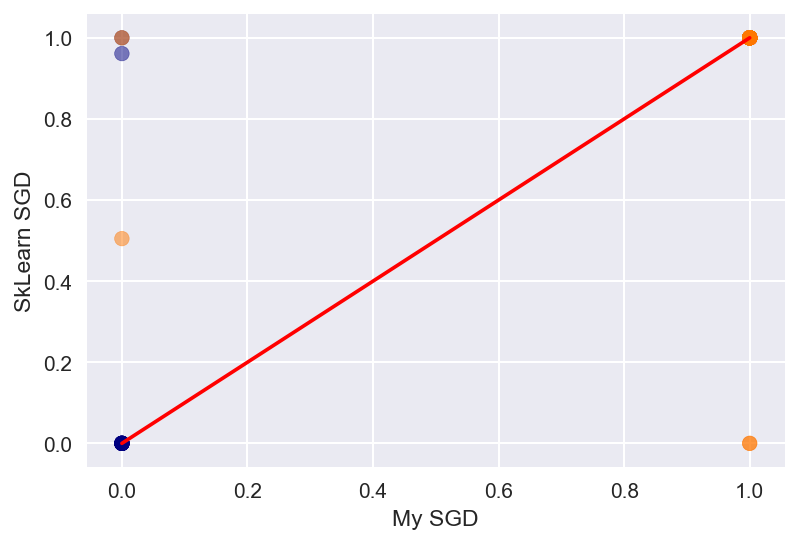

In [43]:
plt.figure(dpi=150)
plt.scatter(my_pred,sk_pred, c=plt.cm.jet(y[500:]*200), alpha=0.5)
plt.xlabel("My SGD")
plt.ylabel("SkLearn SGD");
line_val = np.linspace(min(sk_pred),max(sk_pred),10)
plt.plot(line_val,line_val,'r-');

In [418]:
sgd.score(new_X, y[500:])

0.9710144927536232

In [419]:
sgd_sk.score(new_X,y[500:])

0.94202898550724634